#Alumno: Brian Alex Fuentes Acuña.
#Padrón: 101785

# Clase 15: Control óptimo

Vamos a hacer algunos ejercicios de ejemplo de la [guía 7](https://campus.fi.uba.ar/pluginfile.php/385190/mod_resource/content/9/guia7.pdf). Entraremos en detalles sobre los conceptos a partir de los ejercicios sin mucha introducción al tema por lo que deberías haber mirado la [clase teórica](https://campus.fi.uba.ar/mod/url/view.php?id=170346).

## Ejercicio 2

Para el siguiente sistema discreto:

$$
    x_{k+1} = \left[\begin{matrix}0 & 1\\-1 & 1\end{matrix}\right] x_{k} + \left[\begin{matrix}0\\ 1\end{matrix}\right] u_{k}\\
        x_0 = \left[\begin{matrix}1 \\1\end{matrix}\right]
$$

determinar el control por realimentación de estados que minimiza el criterio:

$$
    J = \frac{1}{2} \sum^{\infty}_{i=1} \left[ (x_{i1})^2 + u_{i}^2\right]
$$

In [ ]:
# Bibliotecas necesarias y funciones auxiliares
!pip install slycot
!pip install control
import control as ctrl
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt


def zplane_plot(eigvals, title='Plano Z - Autovalores'):
    """Grafica autovalores en el plano complejo Z y el circulo unitario de referencia."""
    fig, axes = plt.figure(), plt.gca()
    unit_circle = plt.Circle([0, 0], radius=1, linestyle='--', fill=False)
    axes.add_artist(unit_circle)
    axes.plot(np.real(eigvals), np.imag(eigvals), 'x')
    plt.xlim((-1.5, 1.5))
    plt.ylim((-1.5, 1.5))
    plt.title(title)
    plt.ylabel(r'$\mathscr{Im}(\lambda)$')
    plt.xlabel(r'$\mathscr{Re}(\lambda)$')
    plt.grid()
    plt.show()

Tenemos entonces que minimizar el criterio, que deberemos traducir a la forma:

$$
    J = \frac{1}{2} \sum^{\infty}_{i=1} \left[ x_i^T Q x_i+ u_i^T R u_i\right]
$$

Para extraer las formas cuadráticas que manifiestan los pesos adoptados para el criterio de optimalidad. En este caso serían:

$$
Q =  \begin{bmatrix} 1 & 0\\ 0 & 0\end{bmatrix}
$$

y

$$ R = 1 $$

Esto quiere decir, que estamos ponderando la velocidad de respuesta de la variable de estado $x_{i1}$ y dandole el mismo peso a la acción de control.

Para el control LQR, necesitamos encontrar los $K_i$ que en $i \to \infty$ minimizan dicho criterio. Esto sale de resolver la ecuación algebráica de Riccati:

$$
S = A^T S A - A^T S B \left( R + B^T S B \right)^{-1} B^T S A + Q
$$

Para luego reemplazar en:

$$
K = -\left( R + B^T S B\right)^{-1} B^T S A
$$

Ingresemos los datos y aprovechemos las funciones de la biblioteca de control:

El sistema a controlar es:
 A = [[ 0.  1.]
     [-1. -1.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]

dt = 1

Es controlable.
Es observable.
Tiene autovalores a lazo abierto en [-0.5+0.8660254j -0.5-0.8660254j] sobre el circulo unitario:


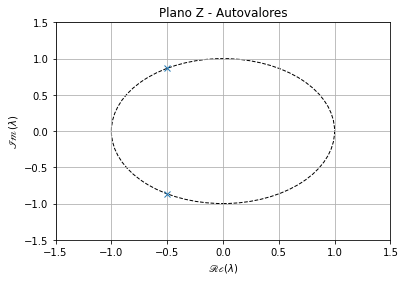

Su función transferencia es: 
     1
-----------
z^2 + z + 1

dt = 1



In [15]:
# Definición del sistema
A = [[0, 1], [-1, -1]]
B = [[0], [1]]
C = [[1, 0]] # El problema no indica la salida, supongamos que es x_1
D = [0]
x0 = [1, 1]
# Como T_s no se indica, asumiremos 1
Ts = 1

sys = ctrl.ss(A, B, C, D, Ts)
print('El sistema a controlar es:\n', sys)

# Definiciones para el control:
Q = [[1, 0], [0, 0]]
R = 1

# Análisis del sistema:
Cm = ctrl.ctrb(sys.A, sys.B)
if (np.linalg.matrix_rank(Cm) == len(sys.A)):
  print('Es controlable.')
else:
  print('No es controlable.')
Om = ctrl.obsv(sys.A, sys.C)
if (np.linalg.matrix_rank(Om) == len(sys.A)):
  print('Es observable.')
else:
  print('No es observable.')

eigvals_openloop = np.linalg.eigvals(sys.A)
print('Tiene autovalores a lazo abierto en', np.linalg.eigvals(sys.A), 'sobre el circulo unitario:')

zplane_plot(eigvals_openloop)

print('Su función transferencia es:', ctrl.tf(sys))

Debemos controlar primero las condiciones de la existencia de K. La controlabilidad (estabilizabilidad) del sistema ya la verificamos. Nos queda:

$ \left\{A, T\right\}$ debe ser detectable, con $T^T T = Q$

Debido al valor de Q, la factorización es directa:

$ T = Q $

Evaluamos:

In [16]:
T = sp.linalg.sqrtm(Q)
Om = ctrl.obsv(sys.A, T)
if (np.linalg.matrix_rank(Om) == len(sys.A)):
  print('Es observable.')
else:
  print('No es observable.')

Es observable.


Esto nos habilita a usar los métodos numéricos disponibles para resolver la ecuación de Riccati y luego calcular el $K$. Todo esto lo resuelve directo la función $\verb|dare()|$

Las ganancias del controlador óptimo son: [[-0.65398566 -0.48586827]]
Los autovalores son: [-0.25706586+0.52908551j -0.25706586-0.52908551j]


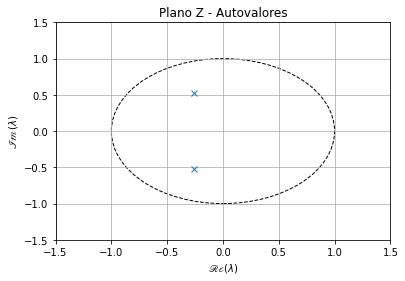

In [17]:
S, L, K = ctrl.dare(sys.A, sys.B, Q, R)
print('Las ganancias del controlador óptimo son:', K)

# Debemos cambiarle el signo:

K = -K

# Definición del sistema a lazo cerrado:

sys_lqr = ctrl.ss(sys.A + sys.B @ K, sys.B, sys.C + sys.D @ K, sys.D, Ts)

#Y se obtienen los siguientes autovalores a lazo cerrado:

# Podría haber usado directo L, devuelta por dare()
eigvals_closedloop = np.linalg.eigvals(sys_lqr.A)
print('Los autovalores son:', eigvals_closedloop)
zplane_plot(eigvals_closedloop)

Comparamos a continuación la respuesta a las condiciones iniciales indicadas. El controlador LQR diseñado debería presentar una respuesta asintóticamente estable, que no tenía a lazo abierto.

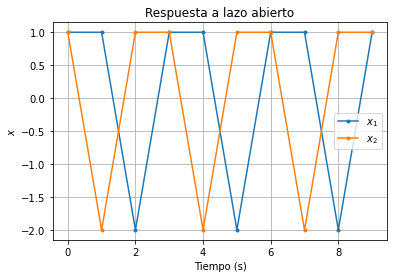

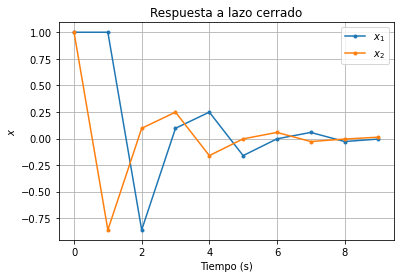

In [18]:
# Tiempos de simulación
t_ini = 0
t_final = 10
t_step = 1
t = np.arange(t_ini, t_final, t_step)

# Simulación y análisis de resultados
_, yout, xout = ctrl.initial_response(sys, t, X0=x0, return_x=True)
plt.plot(t, xout[0,:],'.-', label='$x_1$')
plt.plot(t, xout[1,:],'.-', label='$x_2$')
plt.legend()
plt.title('Respuesta a lazo abierto')
plt.xlabel('Tiempo (s)')
plt.ylabel('$x$')
plt.grid()
plt.show()

plt.figure()
_, yout, xout = ctrl.initial_response(sys_lqr, t, X0=x0, return_x=True)
plt.plot(t, xout[0,:],'.-', label='$x_1$')
plt.plot(t, xout[1,:],'.-', label='$x_2$')
plt.legend()
plt.title('Respuesta a lazo cerrado')
plt.xlabel('Tiempo (s)')
plt.ylabel('$x$')
plt.grid()
plt.show()

Se observa que el controlador óptimo estabiliza la planta. 

## Ejercicio 4:

Para el sistema doble integrador dado por:

$$
    \dot{x} = \left[\begin{matrix}0 & 1\\0 & 0\end{matrix}\right] x + \left[\begin{matrix}0\\ 1\end{matrix}\right] u\\
        y = C x
$$

hallar el control que minimiza el siguiente funcional de costo:

$$
    J = \int^{\infty}_{0} \left( y^Ty + u^Tu \right) dt
$$

dadas las matrices: 

$$
    C_1 = \left[\begin{matrix}1 & 0\end{matrix}\right]\\
    C_2 = \left[\begin{matrix}0 & 1\end{matrix}\right]\\
$$

Para el caso en tiempo continuo, debemos llegar a la siguiente función costo:

$$
    J = \frac{1}{2} \int^{\infty}_{t_0} \left[ x(t)^T Q x(t)+ u(t)^T R u(t)\right] d\tau
$$

Para extraer las formas cuadráticas que manifiestan los pesos adoptados para el criterio de optimalidad. En este caso, el enunciado nos da una pista, ya que nos pide un funcional en donde solo aparece considerada la salida en lugar del estado vector de estado. Entonces:

$$
y^T y = \left(Cx\right)^T C x = x^T C^T C x = x^T Q x
$$

por lo que:

$$ Q = C^T C $$

y

$$ R = 1 $$

Para el control LQR en tiempo continuo, necesitamos encontrar los $K_i$ que en $t \to \infty$ minimizan dicho criterio. Esto sale de resolver la ecuación algebráica de Riccati en tiempo continuo:

$$
P A + A P + Q - P B R^{-1} B^T P = 0
$$

Para luego reemplazar en:

$$
K = - R^{-1} B^T P
$$

Ingresemos los datos y, al igual que con el caso discreto, veremos de utilizar las funciones de la biblioteca de control:


In [19]:
# Definición del sistema
A = [[0, 1], [0, 0]]
B = [[0], [1]]
C1 = [[1, 0]]
C2 = [[0, 1]]
D = [0]
x0 = [-1, 1]

sys = ctrl.ss(A, B, C1, D)
print('El sistema a controlar es:\n', sys)

# Definiciones para el control:
Q = sys.C.transpose() * sys.C
R = 1

# Análisis del sistema:
Cm = ctrl.ctrb(sys.A, sys.B)
if (np.linalg.matrix_rank(Cm) == len(sys.A)):
  print('Es controlable.')
else:
  print('No es controlable.')
Om1 = ctrl.obsv(sys.A, sys.C)
if (np.linalg.matrix_rank(Om1) == len(sys.A)):
  print('Para C1 es observable.')
else:
  print('Para C1 no es observable.')

eigvals_openloop = np.linalg.eigvals(sys.A)
print('Tiene autovalores a lazo abierto en', np.linalg.eigvals(sys.A))

print('Su función transferencia es:', ctrl.tf(sys))

El sistema a controlar es:
 A = [[0. 1.]
     [0. 0.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]

Es controlable.
Para C1 es observable.
Tiene autovalores a lazo abierto en [0. 0.]
Su función transferencia es: 
 1
---
s^2



Al igual que el caso discreto, debemos controlar las condiciones de la existencia de K. La controlabilidad (estabilizabilidad) del sistema ya la verificamos. Verificamos:

$ \left\{A, T\right\}$ debe ser detectable, con $T^T T = Q$

Evaluamos:

In [20]:
# En general podemos factorizar como: 
# T = sp.linalg.sqrtm(Q)
# En este caso está factorizada:
T = sys.C
Om = ctrl.obsv(sys.A, T)
if (np.linalg.matrix_rank(Om) == len(sys.A)):
  print('Es observable.')
else:
  print('No es observable.')

Es observable.


Podemos resover la ecuación de Riccati y hallar $K$ directo con la función $\verb|lqr()|$:

In [21]:
K, S, E = ctrl.lqr(sys, Q, R)
print('Las ganancias del controlador óptimo son:', K)

# Debemos cambiarle el signo:

K = -K

# Definición del sistema a lazo cerrado:

sys_lqr = ctrl.ss(sys.A+sys.B @ K, sys.B, sys.C + sys.D @ K, sys.D)

#Y se obtienen los siguientes autovalores a lazo cerrado:

eigvals_closedloop = np.linalg.eigvals(sys_lqr.A)
print('Los autovalores son:', eigvals_closedloop)

Las ganancias del controlador óptimo son: [[1.         1.41421356]]
Los autovalores son: [-0.70710678+0.70710678j -0.70710678-0.70710678j]


Comparamos a continuación la respuesta a unas condiciones iniciales supuestas para el sistema a lazo abierto y con el controlador LQR diseñado:

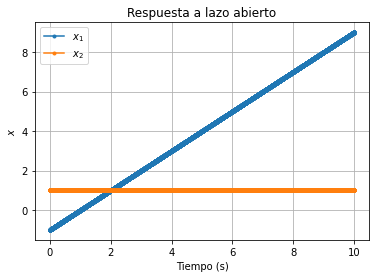

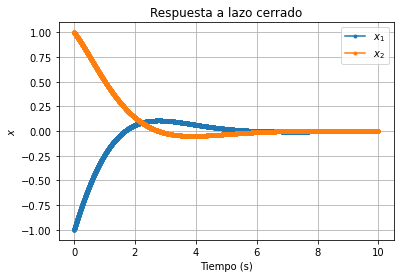

In [28]:
# Tiempos de simulación
t_ini = 0
t_final = 10
t_step = 0.001
t = np.arange(t_ini, t_final, t_step)

# Simulación y análisis de resultados
_, yout, xout = ctrl.initial_response(sys, t, X0=x0, return_x=True)
plt.plot(t, xout[0,:],'.-', label='$x_1$')
plt.plot(t, xout[1,:],'.-', label='$x_2$')
plt.legend()
plt.title('Respuesta a lazo abierto')
plt.xlabel('Tiempo (s)')
plt.ylabel('$x$')
plt.grid()
plt.show()

plt.figure()
_, yout, xout = ctrl.initial_response(sys_lqr, t, X0=x0, return_x=True)
plt.plot(t, xout[0,:],'.-', label='$x_1$')
plt.plot(t, xout[1,:],'.-', label='$x_2$')
plt.legend()
plt.title('Respuesta a lazo cerrado')
plt.xlabel('Tiempo (s)')
plt.ylabel('$x$')
plt.grid()
plt.show()


En el primer gráfico se ve la respuesta a condiciones iniciales del integrador doble, en donde la variable de estado $x_2$ crece indefinidamente. En cambio, se observa que el controlador óptimo estabiliza la planta y hace que ambas variables de estado terminen en 0.
.

## Tarea: 

Resolver el ejercicio para el caso de $C_2$. Explicar. **Pista:** leer sección 11.1.3 del libro de Bay.

In [23]:
sys_ = ctrl.ss(A, B, C2, D)
print('El sistema a controlar es:\n', sys)

# Definiciones para el control:
Q_ = sys_.C.transpose() * sys_.C
R_ = 1

# Análisis del sistema:
Cm_ = ctrl.ctrb(sys_.A, sys_.B)
if (np.linalg.matrix_rank(Cm_) == len(sys_.A)):
  print('Es controlable.')
else:
  print('No es controlable.')
Om1_ = ctrl.obsv(sys_.A, sys_.C)
if (np.linalg.matrix_rank(Om1_) == len(sys_.A)):
  print('Para C2 es observable.')
else:
  print('Para C2 no es observable.')

eigvals_openloop_ = np.linalg.eigvals(sys_.A)
print('Tiene autovalores a lazo abierto en', np.linalg.eigvals(sys_.A))

print('Su función transferencia es:', ctrl.tf(sys))

El sistema a controlar es:
 A = [[0. 1.]
     [0. 0.]]

B = [[0.]
     [1.]]

C = [[1. 0.]]

D = [[0.]]

Es controlable.
Para C2 no es observable.
Tiene autovalores a lazo abierto en [0. 0.]
Su función transferencia es: 
 1
---
s^2



 Debemos volver a controlar las condiciones de la existencia de K. La controlabilidad (estabilizabilidad) del sistema ya la verificamos. Verificamos:

$ \left\{A, T\right\}$ debe ser detectable, con $T^T T = Q$

Evaluamos:

In [24]:
# En general podemos factorizar como: 
# T = sp.linalg.sqrtm(Q)
# En este caso está factorizada:
T_ = sys_.C
Om_ = ctrl.obsv(sys_.A, T_)
if (np.linalg.matrix_rank(Om_) == len(sys_.A)):
  print('Es observable.')
else:
  print('No es observable.')

No es observable.


No es observable, no existe solucion unica, pero esto no nos impide hallar algun controlador optimo.

Podemos resolver la ecuación de Riccati resolviendolo analiticamente.

$$
0= A^T P + PA + C^T C - P B R^1 B^T P
$$

Con P en forma generica:

$$
P= \begin{bmatrix} P_{11} & P_{12} \\ P_{12} & P_{22}\end{bmatrix}
$$
Reemplazando P en la ecuacion.
$$
    \begin{bmatrix} 0 & 0 \\ 0 & 0\end{bmatrix} =
     \left[\begin{matrix}
            -P_{12}^2    &       P_{11} - P_{12}P_{22} \\
          P_{11} - P_{12}P_{22}  & - P_{22}^2 + 2.P_{12} + 1
    \end{matrix}\right]
$$

entonces: 

$P_{12}=P_{11}= 0$ y $ - P_{22}^2 + 1=0$ con raices en $P_{22}= \pm 1$.

solo es definida positiva con $P_{22}= 1$.

Entonces con este P encontrado se puede encontrar una constante de realimentacion K que sea optimo.

segun el libro de **John Bay**:

 "Al pedir que el sistema sea estabilizable, estamos garantizando que existe una retroalimentación K que lleva el estado x (t) asintóticamente a cero y da un costo finito

 Este hecho por sí solo no garantiza que el sistema sea estable si J converge [...].
 
 Para esa garantía necesitamos la otra condición, es decir, detectabilidad."

 Entonces con tener un sistema estabilizable y no detectable solo se puede decir que existe algun K que lleve a los estados asintoticamente a cero, pero no se puede garantizar! para ello se necesita a detectabilidad la cual en esta ocacion no se cumple.

 Entonces veamos como nos queda.



In [25]:
from operator import invert
P=  [[0, 0], [0, 1]]

K_= -R_ * sys_.B.transpose() @ P
print('Las ganancias del controlador óptimo son:', K_)

# Definición del sistema a lazo cerrado:

sys_lqr_ = ctrl.ss(sys_.A+sys_.B @ K_, sys_.B, sys_.C + sys_.D @ K_, sys_.D)

#Y se obtienen los siguientes autovalores a lazo cerrado:

eigvals_closedloop_ = np.linalg.eigvals(sys_lqr_.A)
print('Los autovalores son:', eigvals_closedloop_)


Las ganancias del controlador óptimo son: [[ 0. -1.]]
Los autovalores son: [ 0. -1.]


Se ve que de verdad existe un **K**  y hay un autovalor estable por lo que se tendra que $x_1$ si convergera a cero pero no necesariamente lo hará $x_2$

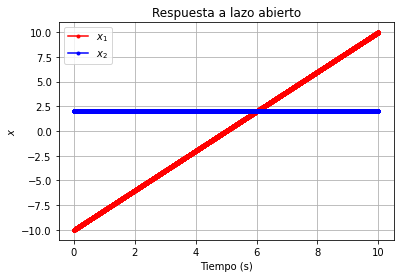

<Figure size 432x288 with 0 Axes>

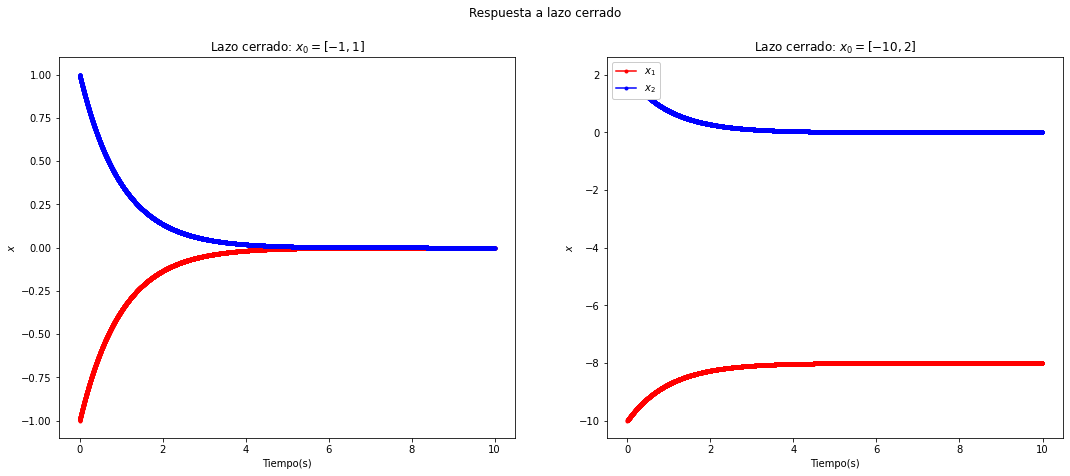

In [26]:
x0_ = [-10, 2]

# Simulación y análisis de resultados
_, yout_, xout_ = ctrl.initial_response(sys_, t, X0=x0_, return_x=True)
plt.plot(t, xout_[0,:],'r.-', label='$x_1$')
plt.plot(t, xout_[1,:],'b.-', label='$x_2$')
plt.legend()
plt.title('Respuesta a lazo abierto')
plt.xlabel('Tiempo (s)')
plt.ylabel('$x$')
plt.grid()
plt.show()


plt.figure()
_, yout_, xout_ = ctrl.initial_response(sys_lqr_, t, X0=x0, return_x=True)
_, yout2_, xout2_ = ctrl.initial_response(sys_lqr_, t, X0=x0_, return_x=True)
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(18,7))

fig.suptitle('Respuesta a lazo cerrado')
ax1.plot(t, xout_[0,:],'r.-', label='$x_1$')
ax1.plot(t, xout_[1,:],'b.-', label='$x_2$')
ax1.set_title("Lazo cerrado: $x_0= [-1, 1]$")
#plt.legend()
ax2.plot(t, xout2_[0,:],'r.-', label='$x_1$')
ax2.plot(t, xout2_[1,:],'b.-', label='$x_2$')
ax2.set_title("Lazo cerrado: $x_0= [-10, 2]$")

ax1.set(xlabel='Tiempo(s)', ylabel= '$x$')
ax2.set(xlabel='Tiempo(s)', ylabel= '$x$')
plt.legend(loc='upper left',framealpha=1,  frameon=True)
plt.show()
fig.tight_layout()

Se observa como con las condiciones iniciales antes usadas pareciera ser que el lazo es asintiticamente estable.

Pero ya cambiando las condiciones iniciales se ve que claramente no es asi, y que solo fue un efecto de la condicion inicial.